The utilites for computing purities from STIM are based on dsicussions I found on these two websites:
    
(1) https://quantumcomputing.stackexchange.com/questions/16718/measuring-entanglement-entropy-using-a-stabilizer-circuit-simulator

(2) https://stackoverflow.com/questions/56856378/fast-computation-of-matrix-rank-over-gf2/56858995#56858995

There is a cell below that checks these STIM-based calculations at N=16 against full circuit simulation using Qiskit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
font = {'family' : 'Helvetica',
        'size'   : 7}
mpl.rc('font', **font)
import pickle
from tqdm import tqdm

from src.purity_utils import circs, stabPurity, partition
    
n_vals = [64]
d_vals = [3, 4, 5, 6, 7]
r_vals = range(1,100+1)
n_vals = range(16,104+1,16)
r_vals = range(1,100+1)

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

## XY Clifford sims at all N

### Be sure to edit purity_utils.py accordingly. On line 30, change the KaHyPar configuration directory appropriately.

In [2]:
def get_random_topology(n, depth, graph=False, final_gates=None):
    topology = []
    if graph:
        assert n % 2 == 0
        depth -= 2
        topology.append([[2 * i, 2 * i + 1] for i in range(n // 2)])
        topology.append([[2 * i + 1, 2 * i + 2] for i in range(n // 2 - 1)] + [[n - 1, 0]])
    for _ in range(depth):
        qubits = [int(j) for j in np.random.permutation([i for i in range(n)])]
        topology.append(list(zip(qubits[::2], qubits[1::2])))
    if final_gates is not None:
        for _ in range(n // 2 - final_gates):
            topology[-1].pop()
    return topology

In [3]:
rho2_clif_xy = {(n,d):[] for n in n_vals for d in d_vals}

samps = range(10)


for n in n_vals:
    for d in tqdm(d_vals):
        for r in r_vals:
            pairs = get_random_topology(n, 2 * d, graph=True)
            raise ValueError('Be sure to edit `src/purity_utils.py` accordingly. On line 30, change the KaHyPar configuration directory appropriately so that it is using the kahypar init file in the environment you are running. Comment the this line of raising error out the next time.')
            part = partition(n, d, 2, pairs[:d])
            for samp in samps:
                s = circs(pairs[:d], pytket = False, xy = True)
                rho2_clif_xy[(n,d)].append(stabPurity(s,part))


with open('rho2_clif_xy.p', 'wb') as f:
    pickle.dump(rho2_clif_xy,f)

100%|██████████| 5/5 [00:36<00:00,  7.23s/it]


## Plot large system results from clifford sims, half partition

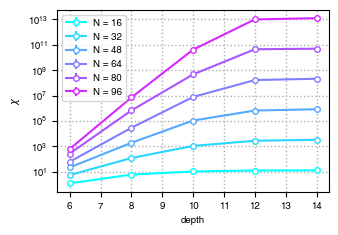

In [5]:
mm = 1/25.4  # millimeters in inches
fig, ax = plt.subplots(figsize=(89 * mm, 60 * mm))


rho2 = rho2_clif_xy


cmap = mpl.colormaps.get_cmap('Blues')
sizes = n_vals
cols = np.linspace(0.3,1.0,len(sizes))
n_cols = {s:cm.cool(i/len(sizes)) for i,s in enumerate(sizes)}

x = np.array(d_vals)

for n in n_vals:
    f = 0.1
    y = np.array([np.mean(rho2[(n,d)]) for d in d_vals])
    yerr = np.array([np.std(rho2[(n,d)])/np.sqrt(len(rho2[(n,d)])) for d in d_vals])    
    chi = f/y
    chierr = f*yerr/y**2
    ax.errorbar(2*x,chi,yerr = chierr, marker = 'o', mfc = 'w', c= n_cols[n], ms = 4, ls = '-', label = f'N = {n}')

                
ax.legend()
ax.set_xlabel('depth')
ax.set_ylabel(r'$\chi$')
ax.set_yticks(10**np.arange(1, 13, 1))
ax.grid(which='both', linestyle=':', linewidth=1)
ax.set_yscale('log')
# plt.savefig('MPS_bond_dimension_half_partitions.pdf', bbox_inches='tight')

plt.show()

# Full partition scheme

In [6]:
rho2_clif_xy = {(n,d):[] for n in n_vals for d in d_vals}

samps = range(10)

for n in n_vals:
    for d in tqdm(d_vals):
        for r in r_vals:
            pairs = get_random_topology(n, 2 * d, graph=True)
            part = partition(n, 2 * d, 2, pairs)
            for samp in samps:
                s = circs(pairs[:d], pytket = False, xy = True)
                rho2_clif_xy[(n,d)].append(stabPurity(s,part))

with open('rho2_clif_xy.p', 'wb') as f:
    pickle.dump(rho2_clif_xy,f)

100%|██████████| 5/5 [00:41<00:00,  8.30s/it]


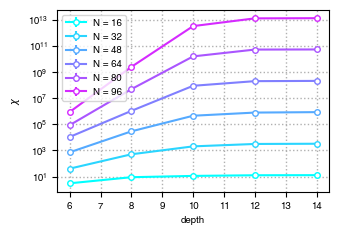

In [8]:
mm = 1/25.4  # millimeters in inches
fig, ax = plt.subplots(figsize=(89 * mm, 60 * mm))


rho2 = rho2_clif_xy


cmap = mpl.colormaps.get_cmap('Blues')
sizes = n_vals
cols = np.linspace(0.3,1.0,len(sizes))
n_cols = {s:cm.cool(i/len(sizes)) for i,s in enumerate(sizes)}

x = np.array(d_vals)

for n in n_vals:
    f = 0.1
    y = np.array([np.mean(rho2[(n,d)]) for d in d_vals])
    yerr = np.array([np.std(rho2[(n,d)])/np.sqrt(len(rho2[(n,d)])) for d in d_vals])    
    chi = f/y
    chierr = f*yerr/y**2
    ax.errorbar(2*x,chi,yerr = chierr, marker = 'o', mfc = 'w', c= n_cols[n], ms = 4, ls = '-', label = f'N = {n}')

                
ax.legend()
ax.set_xlabel('depth')
ax.set_ylabel(r'$\chi$')
ax.set_yticks(10**np.arange(1, 13, 1))
ax.grid(which='both', linestyle=':', linewidth=1)
ax.set_yscale('log')
# plt.savefig('MPS_bond_dimension_full_partitions.pdf', bbox_inches='tight')

plt.show()